In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class grid():
    def __init__(self, n_x, n_y):
        self.n_x = n_x
        self.n_y = n_y
        self.x_points = np.empty(0)
        self.y_points = np.empty(0)
        self.x_max = 1000
        self.y_max = 1000
        self.grid = {}  
        self.elevation = {}
        self.grid_customers = {}  
        self.n_customers = 0      
        self.customer_points = {}
        self.depot = None
        self.d_ij_indices = {}    
        self.d_ij = None          # distances among customers - interface output for the optimization model
        self.d_ij_extended = None
        self.output_matrix = None
        self.tw_a = None
        self.tw_b = None
        self.load = None
        self.servicetime = 5 # minutes
        
        self.create_grid()
        self.grid_dict()
        
    def create_grid(self):
        delta_x = 20
        delta_y = 20
        np.random.seed(1)
        self.x_points = np.linspace(0, self.x_max, self.n_x+1) + np.random.randint(-delta_x, delta_x, self.n_x+1)
        self.y_points = np.linspace(0, self.y_max, self.n_y+1) + np.random.randint(-delta_y, delta_y, self.n_y+1)
        self.x_points[0] = 0; self.x_points[-1] = self.x_max
        self.y_points[0] = 0; self.y_points[-1] = self.y_max
        self.x_points.sort()
        self.y_points.sort()
        
    def grid_dict(self):
        for i in range(self.n_x+1):
            for j in range(self.n_y+1):
                self.grid[(i,j)] = (self.x_points[i], self.y_points[j])
                self.elevation[(i,j)] = 30*np.random.random()
        return self.grid
    
    def time_windows(self, tp='random', min_t=50, max_t=200, k_separation = 0.05, k_overlapped = 0.5):
        tw_a = np.zeros(1, dtype=int); tw_b = np.zeros(1, dtype=int)
        if tp == 'random':
            delta_lower = min_t/2
            delta_upper = delta_lower
            tw_center = np.random.randint(min_t+delta_lower, max_t-delta_upper, self.n_customers)
            self.tw_a = np.append(tw_a, tw_center - np.random.randint(0, delta_lower, self.n_customers))
            self.tw_b = np.append(tw_b, tw_center + np.random.randint(0, delta_upper, self.n_customers))
            return self.tw_a, self.tw_b
        if tp == 'separated':
            delta_tw = (max_t - min_t)/self.n_customers
            self.tw_a = np.append(tw_a, np.array([min_t + (i - k_separation)*delta_tw for i in range(self.n_customers)]) )
            self.tw_b = np.append(tw_b, np.array([min_t + (i + k_separation)*delta_tw for i in range(self.n_customers)]) )
            return self.tw_a, self.tw_b
        if tp == 'overlapped':
            tw_c = (max_t - min_t)/2
            tw_interval = 0.5*k_overlapped*tw_c # half base interval (centered halfway between max_t and min_t)
            delta_interval = np.random.randint(0, tw_interval, self.n_customers)
            self.tw_a = np.append(tw_a, np.array([min_t + tw_c - t for t in sorted(delta_interval)]) )
            self.tw_b = np.append(tw_b, np.array([min_t + tw_c + t for t in sorted(delta_interval)]) )
            # np.random.shuffle(tw_a); np.random.shuffle(tw_b)
            return self.tw_a, self.tw_b
        if tp == 'single':
            self.tw_a = np.append(tw_a, np.array([min_t for _ in range(self.n_customers)]) )
            self.tw_b = np.append(tw_b, np.array([max_t for _ in range(self.n_customers)]) )
            return self.tw_a, self.tw_b
    
    def payload(self, min_p=5, max_p=30):
        self.load = np.append(np.zeros(1), np.random.randint(min_p, max_p, self.n_customers))
    
    def plot_grid(self):
        for i in range(self.n_x+1):
            plt.plot([self.x_points[i], self.x_points[i]], [0, self.y_max], color='gray')
        for j in range(self.n_y+1):
            plt.plot([0, self.x_max], [self.y_points[j], self.y_points[j]], color='gray')
        
    def customers(self, n_customers):
        self.n_customers = n_customers
        random.seed(10); customer_points = random.sample(list(self.grid.items()), n_customers)
        self.customer_points = {k:v for k, v in customer_points}
        return self.customer_points
        
    def plot_customer_points(self):
        k = list(self.customer_points.values())
        self.plot_grid()
        for i in range(self.n_customers):
            plt.scatter(k[i][0], k[i][1])

    def customers_paths(self, depot):
        ### depot must be an appropriate tuple of coordinate indices of the grid: ex (12, 15): (12th pos. on x - 15th pos. on y)
        self.depot = depot
        nodes = list(self.customer_points.keys())
        nodes.insert(0, depot)
        print(nodes)
        delta_indices = np.zeros((self.n_customers+1, self.n_customers+1), dtype=object)
        for i in range(self.n_customers+1):
            print('node:', i, nodes[i])
            for j in range(self.n_customers+1):
                dx_index = nodes[i][0] - nodes[j][0]
                self.d_ij_indices[(i,j)] = ((nodes[i][0], nodes[i][1]), (nodes[i][0]-dx_index, nodes[i][1]), (nodes[j][0], nodes[j][1]))
        
        self.d_ij = np.zeros((self.n_customers+1, self.n_customers+1))
        self.d_ij_extended = np.zeros((2*self.n_customers+1, 2*self.n_customers+1))
        
        for k, v in self.d_ij_indices.items():
            dx = abs(self.grid[v[1]][0] - self.grid[v[0]][0])
            dy = abs(self.grid[v[2]][1] - self.grid[v[1]][1])
            
            self.d_ij[k[0], k[1]] = dx + dy
        
        return self.d_ij
    
    def create_csv(self):
        elevation = np.zeros(self.n_customers)
        service_time = np.zeros(1)
        for i, k in enumerate(self.customer_points.keys()):
            elevation[i] = self.elevation[k]
        elevation = np.append(self.elevation[self.depot], elevation)
        service_time = np.append(service_time, np.array([self.servicetime for _ in range(self.n_customers)]) )
        x = np.append(self.grid[self.depot][0], np.array([v[0] for v in self.customer_points.values()]) )
        y = np.append(self.grid[self.depot][1], np.array([v[1] for v in self.customer_points.values()]) )
        
        self.output_matrix = np.c_[x, y, elevation, self.load, self.tw_a, self.tw_b, service_time, self.d_ij]
        
        header = 'x,y,elevation,demand,tw_a,tw_b,s'
        for i in range(self.n_customers+1):
            header += ','+str(i)
            
        np.savetxt('generated_grid_1.csv', self.output_matrix, delimiter=',', header=header, comments='')
        
        return self.output_matrix

In [3]:
G = grid(20, 25)
print(G.grid[(1,3)])
print(G.grid[(5,3)])

(42.0, 123.0)
(235.0, 123.0)


In [4]:
np.append(np.zeros(1), np.random.randint(5, 10, 5))

array([0., 7., 6., 6., 7., 7.])

In [6]:
a,b = G.time_windows(tp='single', min_t= 50, max_t=400)
print(a)
print(b)

[0.]
[0.]


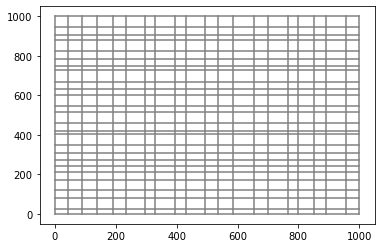

In [7]:
G.plot_grid()

In [8]:
print(np.round(G.x_points, 2))
print(np.round(G.y_points, 2))
print(G.n_x)

[   0.   42.   88.  139.  191.  235.  295.  330.  396.  431.  492.  537.
  586.  655.  700.  767.  798.  850.  891.  958. 1000.]
[   0.   24.   83.  123.  170.  212.  242.  273.  309.  347.  402.  421.
  460.  517.  548.  604.  633.  668.  730.  747.  783.  826.  881.  903.
  944. 1000.]
20


In [9]:
print(G.elevation[(0,0)])
print(G.elevation[(0,5)])

9.465468930181888
29.66583266719484


In [10]:
G.customers(20)
# for i in range(2,5): print(i)

{(1, 7): (42.0, 273.0),
 (16, 23): (798.0, 903.0),
 (19, 0): (958.0, 0.0),
 (0, 15): (0.0, 604.0),
 (8, 3): (396.0, 123.0),
 (18, 5): (891.0, 212.0),
 (19, 9): (958.0, 347.0),
 (10, 24): (492.0, 944.0),
 (6, 8): (295.0, 309.0),
 (1, 9): (42.0, 347.0),
 (20, 13): (1000.0, 517.0),
 (19, 7): (958.0, 273.0),
 (12, 23): (586.0, 903.0),
 (2, 25): (88.0, 1000.0),
 (9, 21): (431.0, 826.0),
 (14, 5): (700.0, 212.0),
 (1, 19): (42.0, 747.0),
 (16, 14): (798.0, 548.0),
 (5, 12): (235.0, 460.0),
 (13, 25): (655.0, 1000.0)}

In [11]:
# G.customer_points

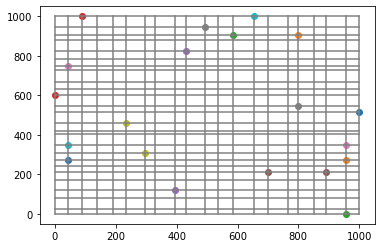

In [12]:
G.plot_customer_points()

In [13]:
G.customers_paths((0,0))

[(0, 0), (1, 7), (16, 23), (19, 0), (0, 15), (8, 3), (18, 5), (19, 9), (10, 24), (6, 8), (1, 9), (20, 13), (19, 7), (12, 23), (2, 25), (9, 21), (14, 5), (1, 19), (16, 14), (5, 12), (13, 25)]
node: 0 (0, 0)
node: 1 (1, 7)
node: 2 (16, 23)
node: 3 (19, 0)
node: 4 (0, 15)
node: 5 (8, 3)
node: 6 (18, 5)
node: 7 (19, 9)
node: 8 (10, 24)
node: 9 (6, 8)
node: 10 (1, 9)
node: 11 (20, 13)
node: 12 (19, 7)
node: 13 (12, 23)
node: 14 (2, 25)
node: 15 (9, 21)
node: 16 (14, 5)
node: 17 (1, 19)
node: 18 (16, 14)
node: 19 (5, 12)
node: 20 (13, 25)


array([[   0.,  315., 1701.,  958.,  604.,  519., 1103., 1305., 1436.,
         604.,  389., 1517., 1231., 1489., 1088., 1257.,  912.,  789.,
        1346.,  695., 1655.],
       [ 315.,    0., 1386., 1189.,  373.,  504.,  910.,  990., 1121.,
         289.,   74., 1202.,  916., 1174.,  773.,  942.,  719.,  474.,
        1031.,  380., 1340.],
       [1701., 1386.,    0., 1063., 1097., 1182.,  784.,  716.,  347.,
        1097., 1312.,  588.,  790.,  212.,  807.,  444.,  789.,  912.,
         355., 1006.,  240.],
       [ 958., 1189., 1063.,    0., 1562.,  685.,  279.,  347., 1410.,
         972., 1263.,  559.,  273., 1275., 1870., 1353.,  470., 1663.,
         708., 1183., 1303.],
       [ 604.,  373., 1097., 1562.,    0.,  877., 1283., 1215.,  832.,
         590.,  299., 1087., 1289.,  885.,  484.,  653., 1092.,  185.,
         854.,  379., 1051.],
       [ 519.,  504., 1182.,  685.,  877.,    0.,  584.,  786.,  917.,
         287.,  578.,  998.,  712.,  970., 1185.,  738.,  393.,  978.

In [14]:
# G.d_ij_indices

In [15]:
# G.d_ij

In [16]:
# print(G.grid_dict()[(0,0)])
# print(G.grid_dict()[(1,7)])
# print(G.grid_dict()[(16,23)])
# print(G.grid_dict()[(19,0)])

In [17]:
# G.customer_points

In [18]:
# for k in G.customer_points.keys():
#     print(k, ' elevation: ', G.elevation[k])

In [19]:
ta, tb = G.time_windows()
print(ta)
print(tb)

[  0  97 111 143  71  67 138 121  87 162 124 116 133  88  58 154 138 133
 115  79 139]
[  0 142 128 176  97  97 175 151 118 171 156 153 172 114  93 167 154 165
 131 122 159]


In [20]:
G.payload()

In [21]:
out = G.create_csv()